**==============================================================================================================================**

# ======================= Assignment 7 ==========================

## Amazon Fine Food Reviews Analysis and Support Vector Classification

​
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>
​
Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 
​
Attribute Information:
​
1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review
​

#### Objective:
1] Implement Decision Tree Classifier

2] Best Hyperparameter using GridSearchCV

3] Compare Model F1 Score with and Without Hyperparameter

a] Most Frequent Words or Features in Positive and Negative Reviews.

6] Confusion Matrix, Comparison of Metrics with Bow, Tfidf, Tfidf-W2V

Classify the Score based on Review and Calculate TPR, FPR, TNR, FNR based on Confusion Matrix

**==============================================================================================================================**

In [1]:
# ============================== loading libraries ===========================================
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import re

import sqlite3


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# =============================================================================================

C:\Users\Ghost\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sqlite3.connect('database.sqlite') 
amzn = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
print("Shape of Amzn Dataframe :",amzn.shape)
print("\n")
print("Head(2) of Amzn Dataframe")
print("**************************")
amzn.head(2)

Shape of Amzn Dataframe : (525814, 10)


Head(2) of Amzn Dataframe
**************************


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


**Function to impute the review to -1- "Positive" (Rating of 4 or 5) or -0- "Negative" (rating of 1 or 2).**

In [3]:
def part(data):
    if data > 3:
        return 1
    else:
        return 0

**Applying Function to Amazon['Score'] factor**

In [4]:
amzn['Score'] = amzn['Score'].map(part)
print("Shape of Amazon Dataframe :",amzn.shape)
amzn.head(2)

print("Score Value: \n",amzn['Score'].value_counts())

Shape of Amazon Dataframe : (525814, 10)
Score Value: 
 1    443777
0     82037
Name: Score, dtype: int64


# Data Preprocessing

**Checking how many observations have Duplicated values in dataset with Variables['UserId','ProfileName','Score','Time']**

**The value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible,
  So Going to keep all the observations which have HelpfulnessNumerator is less than or Equal to HelpfulnessDenominator.**

Sum Of Duplicated Value ['UserId','ProfileName','Score','Time']:  192811

Sum After Removing Duplicated:  0

Shape of Amazon Dataset After Duplication Removal and Erro:  (333001, 10)

1    277625
0     55376
Name: Score, dtype: int64


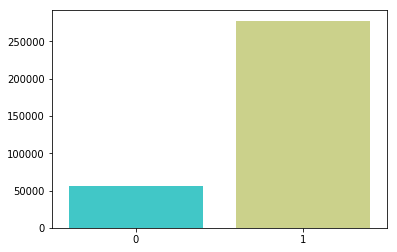

In [5]:
print("Sum Of Duplicated Value ['UserId','ProfileName','Score','Time']: ",amzn.duplicated(subset=['UserId','ProfileName','Score','Time']).sum())
amzn = amzn.drop_duplicates(subset=['UserId','ProfileName','Score','Time'], keep='first')
print()
print("Sum After Removing Duplicated: ",amzn.duplicated().sum())

amzn = amzn[amzn['HelpfulnessNumerator'] <= amzn['HelpfulnessDenominator']]
print()
#Before starting the next phase of preprocessing lets see the number of entries left
print("Shape of Amazon Dataset After Duplication Removal and Erro: ",amzn.shape)
print()
#How many positive and negative reviews are present in our dataset?
class_bal = amzn['Score'].value_counts()
print(class_bal)

#Plotting barplot for target variable to compare balance between them.
sns.barplot(class_bal.index, class_bal.values, palette="rainbow")

**Function which will**

1] Remove all html sets of sentences from reviews

2] Remove all punctuation present in reviews as are not necessary for analysis and modeling

In [6]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

**Code Working**

1] Remove HTMl tags

2] Split the reviews

3] Converting reviews to lower case

4] Removing Stop words

5] Storing of all words used to describe positive reviews and negative reviews.

In [8]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''


for sent in amzn['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower()))
                    filtered_sentence.append(s)
                    if (amzn['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(amzn['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1

**Adding a column of CleanedText which displays the data after pre-processing of the review**

**Taking Sample of 100000 Observation after preprocess of data and after sorting all the data.**

In [9]:
amzn['CleanedText'] = final_string
amzn = amzn.sort_values('Time')

amazon = amzn.head(50000)
print(amazon.shape)

amazon.head(2)

(50000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...


# =============================================================
# =============================================================
# =============================================================

**Spliting data to train and test as 35000-15000 for further steps and analysis**

In [10]:
X_train = amazon['CleanedText'].head(35000)
X_test = amazon['CleanedText'].tail(15000)
y_train = amazon['Score'].head(35000)
y_test = amazon['Score'].tail(15000)

print("Text:  ",len(X_train), len(X_test), len(X_train) + len(X_test))
print("Score: ",len(y_train), len(y_test), len(y_train) + len(y_test))

Text:   35000 15000 50000
Score:  35000 15000 50000


# Functions to call again and again whenever needed

**Function takes Train and test data to find better Alpha value and GridCv Function to perform Cross Validation to find Better Alpha (Laplace Smoothing)** 

In [11]:
def SVC_Without_Tunning(X_train, y_train, X_test, y_test):

    svm = SVC()

    # fitting the model on crossvalidation train-
    svm.fit(X_train, y_train)
        
    # predict the response on the crossvalidation train
    pred = svm.predict(X_test)

    # evaluate Accuracy
    acc = accuracy_score(y_test, pred, normalize=True) * float(100)
    F1_Score = f1_score(y_test, pred,average='weighted') * float(100)
        
    print("====================================================")
    print('Accuracy: ',acc,'%')
    print('F1 Score: ',F1_Score,'%')
    print("====================================================")
    print()
        

        
def Grid_CV(X_train, y_train): 
    params = {'gamma':[100,10,1,0.1,0.01], 'C':[100,10,1,0.1,0.01]}
    classifier = SVC()
    grid_search = GridSearchCV(estimator=classifier, param_grid=params, scoring = 'f1', cv = 2, n_jobs=-1)
    grid_search = grid_search.fit(X_train, y_train)
    print("Grid Search CV Best With Hypermeter According to F1_Score Are:")        
    print("==============================================================")
    print("Best HyperParameter: ",grid_search.best_params_)
    print("Best Accuracy: %.2f%%"%(grid_search.best_score_*100))
    

def Random_CV(X_train, y_train):
    params = {'gamma':[100,0.01],'C':[100,0.01]}
    tuned_classifier = SVC()
    rand_search = RandomizedSearchCV(estimator=tuned_classifier, param_distributions=params, scoring = 'f1', cv = 2, n_jobs=-1)
    rand_search = rand_search.fit(X_train, y_train)
    print("Grid Search CV Best With Hypermeter According to F1_Score Are:")      
    print("==============================================================")
    print("Best HyperParameter: ",rand_search.best_params_)
    print("Best Accuracy: %.2f%%"%(rand_search.best_score_*100))

**Function to print Confusion Matrix, CV Score, Classification Report, Plot Confusion Matrix and Get Accuracy of Model on Test Data with Defined Classifier with Better Alpha**

In [12]:
def fit_predict_Metrics_CM(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    
    cv_perfor = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=2)
    k_fold_performance = cv_perfor.mean()
    
    print("K-fold cross validation score of model for k = 2 is :")
    print(k_fold_performance * float(100))
    print("==========================================")
    print("==========================================")
    print()
    
    print("Correct Classified Data Point: ",accuracy_score(y_test, prediction, normalize=False))
    print()
    print("Accuracy on test set: %0.2f%%"%(accuracy_score(y_test, prediction)*100))
    print("==========================================")
    print("Precision on test set: %0.2f"%(precision_score(y_test, prediction)*100))
    print("==========================================")
    print("Recall on test set: %0.2f"%(recall_score(y_test, prediction)*100))
    print("==========================================")
    print("F1-Score on test set: %0.2f"%(f1_score(y_test, prediction)*100))
    print("==========================================")
    
    cm = confusion_matrix(y_test,prediction)
    

    df_CM = pd.DataFrame(cm)
    print()
    print()
    print("Confusion Matrix")
    print("==================")
    print(df_CM)
    print("==================")
    fig = plt.figure()
    sns.heatmap(df_CM, annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    print()

In [13]:
### Function for Word Cloud to Visualize Important Features in Positive and Negative Review or Most occuring Words in Reviews

def wordimpcloud(data):
    # nltk.FreqDist generates a tally of the number of times each word appears
    # and stores the results in a special dictionary.
    fdist = nltk.FreqDist(data)

    # This is the dictionary we'll use for the word cloud.
    # Loaded with the FOR loop below.
    word_dict = {}

    for key in fdist:
        word_dict[key] = fdist[key]

    wordCloud = WordCloud(max_words= 500, height= 1500, width= 3000)

    print("\nWord cloud with most frequently occurring Words (unigrams).")

    wordCloud.generate_from_frequencies(word_dict)
    plt.figure(figsize=(15,30))
    plt.title('Most frequently occurring words (unigrams)')
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [14]:
y_train = y_train.values
y_test = y_test.values

# =============================================================
# =============================================================
# =============================================================

# Bag Of Words(BoW)

**Creating Bag of words using CountVectorizer() function and printing Shape of same and Unique words present in reviews**

In [15]:
#BoW
CV = CountVectorizer() #in scikit-learn
Bow_X_train = CV.fit_transform(X_train)
Bow_X_test = CV.transform(X_test)
print("Shape of BOW vectorizer: ",Bow_X_train.get_shape(), Bow_X_test.get_shape())
print("Number of unique words in 'Bow_X_train': ", Bow_X_train.get_shape()[1])
print("Number of unique words in 'Bow_X_test': ", Bow_X_test.get_shape()[1])

Shape of BOW vectorizer:  (35000, 23224) (15000, 23224)
Number of unique words in 'Bow_X_train':  23224
Number of unique words in 'Bow_X_test':  23224


## Modelling without Hypertuning

In [17]:
warnings.filterwarnings('ignore')
SVC_Without_Tunning(Bow_X_train, y_train, Bow_X_test, y_test)

Accuracy:  87.39333333333333 %
F1 Score:  81.5140493554852 %



### Best Hyperparameter Using Grid Search CV with F1

In [ ]:
Grid_CV(Bow_X_train, y_train)

### Modelling with Best Hyperparameter by GridSearchCV

K-fold cross validation score of model for k = 3 is :
88.63375013707476

Correct Classified Data Point:  17388

Accuracy on test set: 86.940%
Precision on test set: 87.377
Recall on test set: 98.986
F1-Score on test set: 92.820


Confusion Matrix
     0      1
0  505   2439
1  173  16883



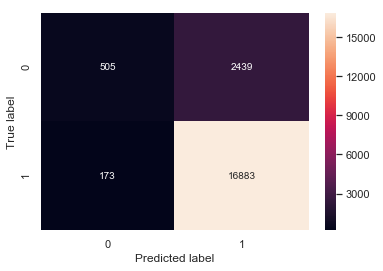

In [73]:
classifier = DecisionTreeClassifier(criterion='gini', class_weight={0: 0.4, 1: 0.6}, max_depth=10, random_state=1)
fit_predict_performance_CM_CV(classifier, Bow_X_train, y_train, Bow_X_test, y_test)

In [ ]:
Random_CV(Bow_X_train, y_train)

**==================================================================================================================================**

**Observation on BoW Decision Tree:**

1] After Implementing different approach to find better Hyperpemeter such as
    - Criterion
    - Max-Depth
    - Class Weight
    
With,

    - GridSearchCV : Criterion = 'gini' 
                     Max-Depth = 10
                     Class-Weight = {0:0.4,1:0.6)


Results:

    - Test Result: 86.94 %
    - CV Result: 88.63 %
    
    - Accuracy:
        - F1 Score: 92.81 %
        - Recall: 87 %
        - Precision: 85 %
        
    - Correctly Classified Points: 17388/20000
    

**==================================================================================================================================**

# Most Frequent Feature Words in Postive and Negative Reviews

In [24]:
freq_positive_dist=nltk.FreqDist(all_positive_words)
freq_negative_dist=nltk.FreqDist(all_negative_words)
print("Most Common and Top Feature Words in Positive Review")
print("====================================================")
print(freq_positive_dist.most_common(50))
print()
print("Most Common and Top Feature Words in Negative Review")
print("====================================================")
print(freq_negative_dist.most_common(50))

Most Common and Top Feature Words in Positive Review
[('like', 124538), ('tast', 115988), ('good', 100085), ('flavor', 96603), ('love', 96593), ('use', 93419), ('great', 92881), ('one', 87018), ('product', 82702), ('tri', 79105), ('tea', 74536), ('coffe', 72974), ('make', 67057), ('get', 65275), ('food', 58135), ('would', 50525), ('time', 50143), ('buy', 49144), ('realli', 47133), ('eat', 46242), ('amazon', 45696), ('price', 44206), ('find', 44161), ('best', 43617), ('much', 43079), ('order', 42989), ('also', 42655), ('dont', 41800), ('littl', 41225), ('drink', 38953), ('well', 38691), ('store', 38196), ('dog', 37783), ('ive', 37276), ('bag', 36833), ('even', 34969), ('day', 32899), ('better', 32811), ('mix', 32739), ('chocol', 32254), ('year', 31394), ('recommend', 31119), ('water', 29556), ('sweet', 29509), ('sugar', 29070), ('box', 29032), ('found', 28435), ('cup', 28012), ('first', 27732), ('give', 26991)]

Most Common and Top Feature Words in Negative Review
[('tast', 33462), ('li

## Important Word Features In Positive Reviews


Word cloud with most frequently occurring Words (unigrams).


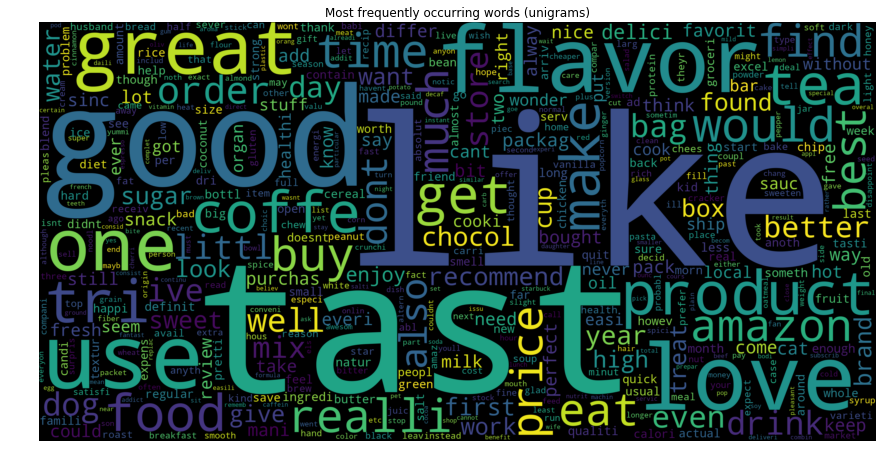

In [33]:
wordimpcloud(all_positive_words)

## Important Word Features In Negative Reviews


Word cloud with most frequently occurring Words (unigrams).


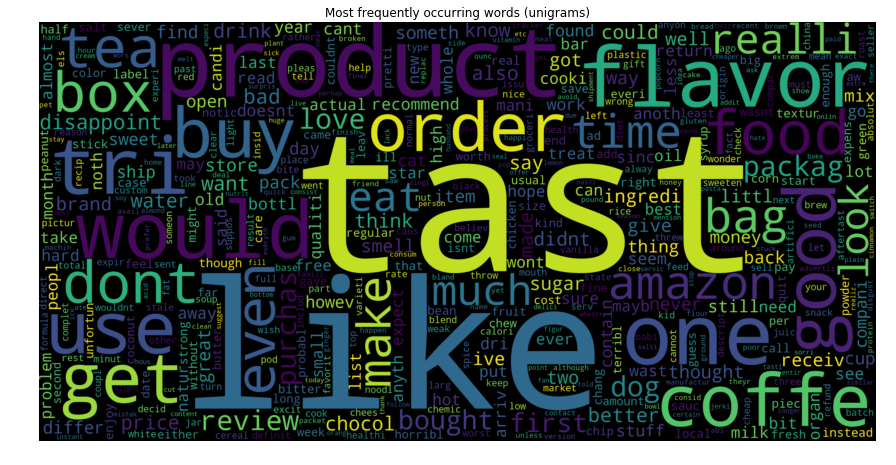

In [34]:
wordimpcloud(all_negative_words)

# Tf-Idf

**Tfidf and finding Shape of data and Unique words in Dataframe**

In [28]:
tf_idf = TfidfVectorizer()
Tfidf_X_train = tf_idf.fit_transform(X_train)
Tfidf_X_test = tf_idf.transform(X_test)
print("Shape of BOW vectorizer: ",Tfidf_X_train.get_shape(), Tfidf_X_test.get_shape())
print("Number of unique words in 'Tfidf_X_train': ", Tfidf_X_train.get_shape()[1])
print("Number of unique words in 'Tfidf_X_test': ", Tfidf_X_test.get_shape()[1])

Shape of BOW vectorizer:  (80000, 33721) (20000, 33721)
Number of unique words in 'Tfidf_X_train':  33721
Number of unique words in 'Tfidf_X_test':  33721


# Top 10 Features in Tfidf

In [24]:
# source: https://buhrmann.github.io/tfidf-analysis.html
features = tf_idf.get_feature_names()
def top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(Tfidf_X_train[1,:].toarray()[0],features,10)
top_tfidf

,feature,tfidf
0,book,0.365523
1,televis,0.269617
2,song,0.259891
3,preschool,0.258105
4,thirti,0.239940
5,teach,0.239476
6,seri,0.237260
7,student,0.216004
8,sister,0.189603
9,air,0.184065


### Modelling without Hypertuning

In [30]:
dtree_train_test_withouthypertunning(Tfidf_X_train, y_train, Tfidf_X_test, y_test)

Accuracy:  84.87 %
F1 Score:  84.46872518788993 %



### Best Hyperparameter Using Grid Search CV with F1

In [31]:
Grid_CV(Tfidf_X_train, y_train)

Grid Search CV Best With Hypermeter According to F1_Score Are:
{'class_weight': {0: 0.4, 1: 0.6}, 'criterion': 'gini', 'max_depth': 12, 'random_state': 1}


## Modelling with Best Hyperparameter by GridSearchCV

K-fold cross validation score of model for k = 3 is :
88.69250080897652

Correct Classified Data Point:  17384

Accuracy on test set: 86.920%
Precision on test set: 87.402
Recall on test set: 98.921
F1-Score on test set: 92.805


Confusion Matrix
     0      1
0  512   2432
1  184  16872



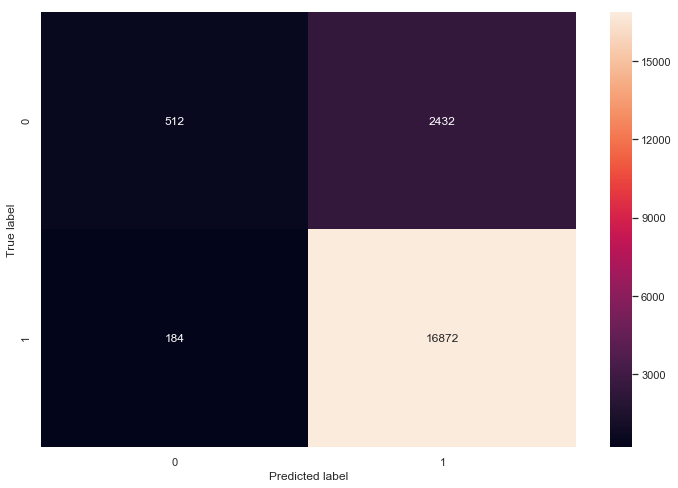

In [75]:
classifier = DecisionTreeClassifier(class_weight={0: 0.4, 1: 0.6}, criterion='gini', max_depth=12, random_state=1)
fit_predict_performance_CM_CV(classifier, Tfidf_X_train, y_train, Tfidf_X_test, y_test)

## Top Features using Tfidf

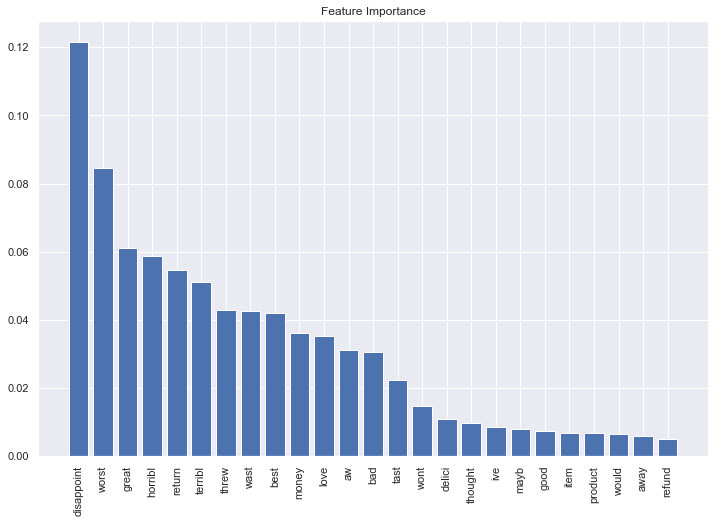

In [76]:
# Calculate feature importances from decision trees
top_feat = classifier.feature_importances_

# Sort feature importances in descending order
sort_feat = np.argsort(top_feat)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = tf_idf.get_feature_names()

sns.set(rc={'figure.figsize':(12,8)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), top_feat[sort_feat])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[sort_feat], rotation=90)

# Show plot
plt.show()

**==================================================================================================================================**

**Observation on Tfidf Decision Tree:**

1] After Implementing different approach to find better Hyperpemeter such as
    - Criterion
    - Max-Depth
    - Class Weight
    
With,

    - GridSearchCV : Criterion = 'gini' 
                     Max-Depth = 12
                     Class-Weight = {0:0.4,1:0.6)


Results:

    - Test Result: 85.68 %
    - CV Result: 88.69 %
    
    - Accuracy:
        - F1 Score: 92.8 %
        - Recall: 87 %
        - Precision: 85 %
        
    - Correctly Classified Points: 17384/20000
    

**==================================================================================================================================**

# Word2Vec

# Tfidf Word2Vec

### Word2Vec

In [33]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_train[:]:
    list_of_sent.append(sent.split())

In [34]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_test=[]
for sent in X_test[:]:
    list_of_sent_test.append(sent.split())

In [35]:
print(list_of_sent[0])

['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [36]:
# min_count = 10 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent, min_count= 10 ,size = 150, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 10 times ",len(w2v_words))
print("\nsample words:", w2v_words[0:50])

number of words that occured minimum 10 times  8096

sample words: ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school']


In [37]:
w2v_model.wv['love']

array([-0.89874196,  0.23757559,  1.879676  , -0.3302068 , -1.2673163 ,
        1.0627879 ,  0.3769071 , -0.42064235,  2.0325787 ,  0.4629616 ,
        0.61651033,  0.29817823,  0.7744085 ,  0.7041313 ,  0.18428904,
       -0.12432134,  0.16322123, -0.64739436, -0.22228922, -0.1390676 ,
        0.48327678,  0.43257153,  0.66554755, -0.59664196, -0.14782077,
       -0.14823453,  0.01215556, -0.2877857 , -0.9637426 , -1.1154512 ,
       -0.45958602, -0.91186553,  0.3406402 ,  0.35923526,  1.2173012 ,
        0.16232441,  0.03810761,  0.7058441 ,  0.6390798 ,  1.1237646 ,
        0.49880195,  0.02640508, -0.41357738, -0.39549085, -0.4915457 ,
        2.4795046 ,  2.5338237 , -1.1089127 ,  0.14502563, -0.12125552,
       -0.88935876, -0.21613058, -0.4409718 ,  0.37151343, -0.91660243,
       -1.1701978 , -1.16974   ,  0.08197094,  0.5722401 , -0.5896675 ,
        1.394959  , -1.9008058 ,  1.8893465 , -1.0747284 ,  0.19766557,
       -0.31150955,  0.41353697,  0.88429904, -0.08897874, -1.05

## Tfidf W2V

**Creating Tfidf for Word 2 Vector, Creating dictionary with each word as key and values as its vector and computed tfidf.**

In [38]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
tf_idf_matrix_test = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

**Creating Vector of Train data using W2V Model**

In [39]:
tfidf_feat = model.get_feature_names()
# average Word2Vec
# compute average word2vec for each review in train data

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(150) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            Tf_idf_w2v_train = dictionary[word]*sent.count(word)
            #Tf_idf_w2v_train = Tfidf_X_train[row, tf_idf.get_feature_names().index(word)]
            sent_vec += (vec * Tf_idf_w2v_train)
            weight_sum += Tf_idf_w2v_train
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

**Creating Vector of Train data using W2V Model**

In [40]:
# average Word2Vec
# compute average word2vec for each review in test data

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(150) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            Tf_idf_w2v_test = dictionary[word]*sent.count(word)
            sent_vec += (vec * Tf_idf_w2v_test)
            weight_sum += Tf_idf_w2v_test
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

**Array of w2v vectorizer for further analysis**

In [41]:
tfidfw2v_train = tfidf_sent_vectors_train
tfidfw2v_test = tfidf_sent_vectors_test

In [44]:
tfidfw2v_train = scipy.sparse.csr_matrix(tfidfw2v_train)
tfidfw2v_test = scipy.sparse.csr_matrix(tfidfw2v_test)

### Modelling without Hypertuning

In [45]:
dtree_train_test_withouthypertunning(tfidfw2v_train, y_train, tfidfw2v_test, y_test)

Accuracy:  80.675 %
F1 Score:  80.8300066069862 %



### Best Hyperparameter Using Grid Search CV with F1

In [46]:
Grid_CV(tfidfw2v_train, y_train)

Grid Search CV Best With Hypermeter According to F1_Score Are:
{'class_weight': {0: 0.4, 1: 0.6}, 'criterion': 'entropy', 'max_depth': 6, 'random_state': 1}


## Modelling with Best Hyperparameter by GridSearchCV

K-fold cross validation score of model for k = 3 is :
87.48749876169937

Correct Classified Data Point:  17137

Accuracy on test set: 85.685%
Precision on test set: 86.212
Recall on test set: 99.056
F1-Score on test set: 92.189


Confusion Matrix
     0      1
0  242   2702
1  161  16895



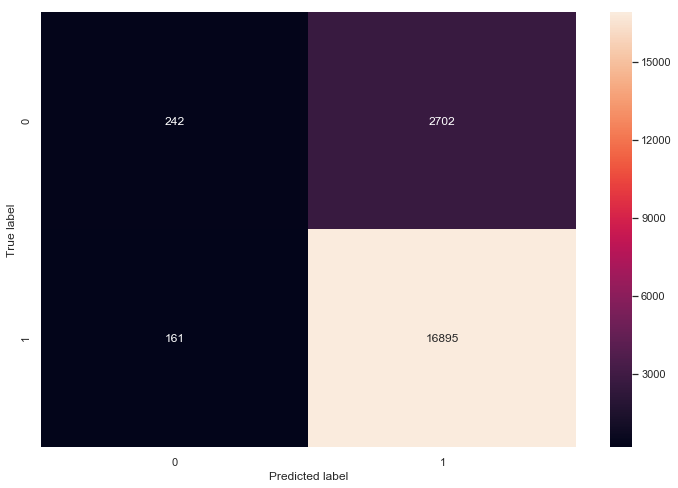

In [77]:
classifier = DecisionTreeClassifier(criterion='entropy', class_weight={0: 0.4, 1: 0.6}, max_depth=6, random_state=1)
fit_predict_performance_CM_CV(classifier, tfidfw2v_train, y_train, tfidfw2v_test, y_test)

**==================================================================================================================================**

**Observation on Tfidf-W2V Naive Bayes:**

1] After Implementing different approach to find better Hyperpemeter such as
    - Criterion
    - Max-Depth
    - Class Weight
    
With,

    - GridSearchCV : Criterion = 'entropy' 
                     Max-Depth = 6
                     Class-Weight = {0:0.4,1:0.6)


Results:

    - Test Result: 85.68 %
    - CV Result: 87.48 %
    
    - Accuracy:
        - F1 Score: 92 %
        - Recall: 86 %
        - Precision: 82 %
        
    - Correctly Classified Points: 17137/20000
    

**==================================================================================================================================**

## Conclusion and Observation Table

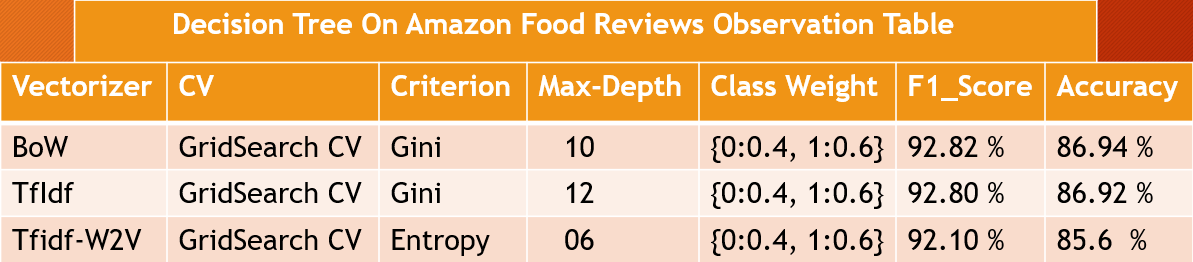

In [78]:
img = 'C:/Users/Ghost/Downloads/AAIC Assignment/SVACC.png'
Image(img)

**Conclusion:**

**1] Tfidf have maximum depth after running GridSearchCv = 12 with Accuracy: 86.92% and F1: 92.82 %**

**2] Bow have maximum F1 Score for model with a Depth of 10 which is less than Tfidf Vectorizer Model.**

**3] Tfidf-W2V have different Criterion "Entorpy" with Max-Depth: 06 that have Accucracy: 85.6% and F1-Score: 92.10% that is not bad with this depth and with entropy gain.**

